Reviewed: Jan 2024

This notebook may be run in Colab

To run this code on the GPU:

**Runtime -> Change runtime type -> GPU**

# Building a NN using PyTorch

Given an image of a clothing item, we will predict the item.
We will show how to add layers to a NN using [nn.Torch](https://pytorch.org/docs/stable/nn.html), and [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) which
is an ordered container of modules. The data is passed through all the modules in the same order as defined.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim   # SGD
import time

In [2]:
#Check if GPU is available. The program will run using the GPU if available,
#otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

False

## The Fashion MNIST data

We will use 4096 training images, and 1024 validation images. (Normally, when we train neural networks, we will try to use all the data that we have. The only reason I'm limiting our training and validation set is so that the code runs quickly for demonstration purposes.)

1.4%

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




6.7%

100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



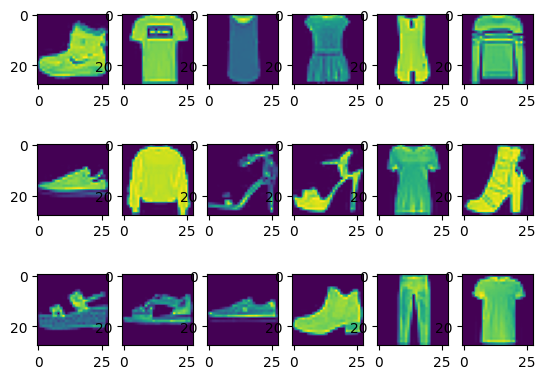

In [3]:
mnist_images = datasets.FashionMNIST('data', train=True, download=True)

for k, (image, label) in enumerate(mnist_images):
    if k >= 18:
        break
    plt.subplot(3, 6, k+1)
    plt.imshow(image)

In [4]:
#Convert to images to tensor format. The data has been downloaded in the previous code
# chunk `download=True`, so no need to download again here.
mnist_data = datasets.FashionMNIST('data', train=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)

#Take a small subset for testing the program
#When the program works, run it on all the data
#May not be feasible if data is huge and access to limited computing power
# in which case pick a larger sample but not too big.
mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

In [5]:
# no. obs in train and validation sets
len(mnist_train), len(mnist_val)

(4096, 1024)

## The model

[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is the base class for **all** NN modules. It contains the methods for NN training.

[nn.Sequential]((https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is a subclass of NN.Module.
It allows for chaining of the layers and is a quick way to build a NN when this is allowed.

Depending on the architecture of the NN, we may use nn.Module, or nn.Sequential, or both to build our model.

Here, we will fit a softmax regression, which chaining together a vectorised layer and a linear layer. (There is a softmax operation which we will discuss shortly).

Each image is 28 x 28.

Define the model `model` so that and input image is:

**flattened (vectorised) --> linear layer that has 10 outputs -->Classify with softmax.**

PyTorch does not implicitly reshape the inputs. Thus define the flatten
layer [`nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to reshape the inputs (to a vector) before the linear layer in the network.

In [6]:
# NN without dropout
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28*28, 180),
                      nn.ReLU(),
                      nn.Linear(180,180),
                      nn.ReLU(),
                      nn.Linear(180,10))

In [8]:
# NN with dropout
dropout = 0.5 # probability of dropping out a unit

num_L1_out = 180
num_L2_out= 180
num_output = 10

model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28*28, num_L1_out),
                      nn.BatchNorm1d(num_L1_out),
                      nn.ReLU(),
                      # Add a dropout layer after the first fully connected layer
                      nn.Dropout(dropout),
                      nn.Linear(num_L1_out,num_L2_out),
                      nn.BatchNorm1d(num_L2_out),
                      nn.ReLU(),
                      # Add a dropout layer after the 2nd fully connected layer
                      nn.Dropout(dropout),
                      nn.Linear(num_L2_out,num_output))

In [9]:
# Do not run this if you wish to use the default setting to initialise
# the parameters in nn.torch
def init_weights(m):
    "Initialise weights to the linear layer"
    if type(m) == nn.Linear:
        nn.init.normal_(tensor=m.weight, mean=0.0,std=0.01)
        #nn.init.zeros_(tensor=m.weight)
        #nn.init.zeros_(tensor=m.bias)
        #nn.init.ones_(tensor=m.weight)
        nn.init.xavier_normal_(tensor=m.weight)

model.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=180, bias=True)
  (2): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=180, out_features=180, bias=True)
  (6): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=180, out_features=10, bias=True)
)

If we run the forward pass -- or attempt to make predictions, we will get something like this:

The tensor output shows the activation of the 10 output neurons in our neural network. We still need to go from this output to either a (discrete) prediction, or a (continuous) distribution showing a computed probability of the image belonging to each class (each digit).

The output of the linear layer, the logits, is passed through a softmax function to obtain probabilities - this is handled by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) so we do not add it into our chain.


In [10]:
#Set up device to do computation. Device is either cpu or gpu.
#Set device = gpu if gpu available
device = torch.device("cuda" if cuda else "cpu")

#Transfer model to device. (Also have to transfer data to device, which will do later)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=180, bias=True)
  (2): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=180, out_features=180, bias=True)
  (6): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=180, out_features=10, bias=True)
)

## Training

In [12]:
def train(model, train_data, val_data, batch_size=64, num_epochs=1):

    """
    For num_epoch of times, iterate over the mini-batches and
    and update the parameters at each iteration.
    Record the training loss, and validation error, and plot each over iterations.
    At the start of each epoch the data is shuffled and a new set of
    mini-batches is created.

    Parameters:

        model: the neural net
        train_data: training set
        val_data: validation set
        batch_size (int): mini-batch size of training and validation sets
        num_epochs(int): number of epochs to train

    Returns:

        None
    """

    train_loader = DataLoader(train_data,batch_size=batch_size,
                                               shuffle=True)

    #Pick loss and optimiser to use in training
    #Inialise loss
    criterion = nn.CrossEntropyLoss()
    #Initialise optimizer
    optimizer = optim.SGD(model.parameters(), weight_decay=0.02, lr=0.01) # SGD + weight decay

    #Store evaluation metrics
    iters, losses, train_acc, val_acc = [], [], [], []

    # Training loop
    n = 0 # the number of iterations
    start_time = time.time()

    #Put model into training mode
    #model.train()

    for epoch in range(num_epochs):

        #Iterate over the mini-batches
        for imgs, labels in iter(train_loader):

            #Put model into training mode
            # This tells certain layers of NN to behave in a certain
            # during training e.g. dropout
            model.train()

            # Transfer data to device
            imgs = imgs.to(device)
            labels = labels.to(device)

            #Forward pass: outputs logits for each image and computes the loss value
            out = model(imgs)
            loss = criterion(out, labels)


            #Backward pass and update
            loss.backward()               # Backprop
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()              # Update each parameter
            optimizer.zero_grad()         # reset gradients

        # Save the current training information to report
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_data)) # compute training accuracy
        val_acc.append(get_accuracy(model, val_data))  # compute validation accuracy
        n += 1

        #End of the epoch
        end_time = time.time()
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {round(losses[-1],5)}, Time: {round(end_time - start_time,5)}s')
    #Completed all epochs
    # plotting
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

`get_accuracy` helper function. To turn the probabilities into a discrete prediction, we will take the digit with the highest probability. Because of the way softmax is computed, the digit with the highest probability is the same as the digit with the (pre-activation) output value.

In [13]:
def get_accuracy(model, data):
    """
    Computes the accuracy of data.
    Accuracy is defined as number correct predictions/ Total
    number of predictions made.

    This function is called from inside the training loop.

    Returns accuracy, a scalar.
    """
    # set model to evaluation mode for prediction
    #This is required as certain layers bhave differently
    #depending on whether it is used for training or prediction.
    model.eval()

    correct = 0
    total = 0
    for imgs, labels in DataLoader(data, batch_size=64):
        # Transfer data to device
        #imgs = imgs.to(device)
        #labels = labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Debugging

One technique that researchers often use to debug their network is to first make sure that their network can overfit to a small dataset. This sanity check ensures that you are using the right variable names, and rules out other programming bugs that are difficult to discern from architecture issues.

Common programming issues that can arise include:

Forgetting to call optimizer.zero_grad() when using PyTorch. In general, this line of code is included at the beginning of the code for a training iteration, as opposed to at the end.
Using the wrong criterion, or using a loss function with incorrectly formated variables.
Adding a non-linearity after the final layer. In general we don't add a non-linearity in the forward function of the network, so that the computation of the loss function and the associated optimization steps are more numerically stable.
Forgetting non-linearity layers in the forward function.

Training Loss in epoch 1/5: 0.04665, Time: 0.09029s
Training Loss in epoch 2/5: 0.04843, Time: 0.09235s
Training Loss in epoch 3/5: 0.04625, Time: 0.09386s
Training Loss in epoch 4/5: 0.04414, Time: 0.09535s
Training Loss in epoch 5/5: 0.04343, Time: 0.09709s


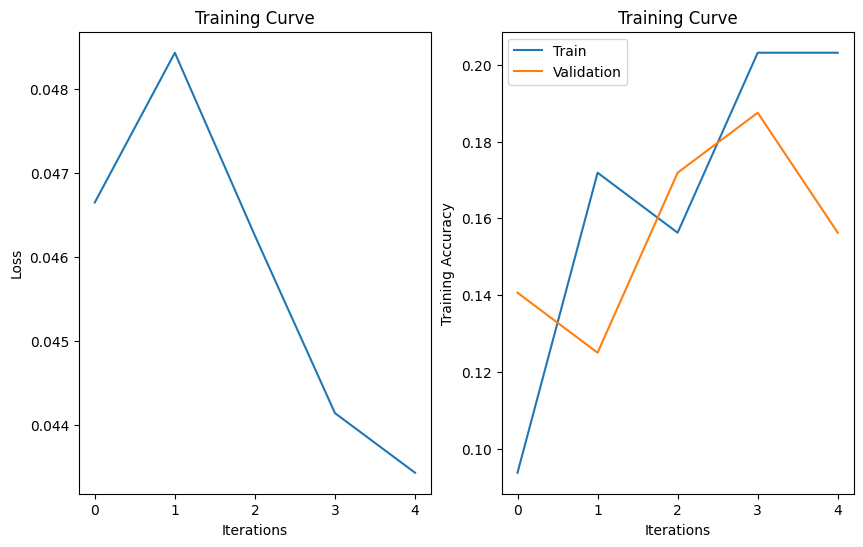

Final Training Accuracy: 0.203125
Final Validation Accuracy: 0.15625


In [14]:
debug_train_data = mnist_train[:64] #sample size = batch size
debug_val_data = mnist_val[:64]
train(model, debug_train_data, debug_val_data,num_epochs=5)

Only when we have ensured that our model can overfit to a small dataset do we begin training the neural network our full training set.

Training Loss in epoch 1/600: 0.02212, Time: 0.11038s
Training Loss in epoch 2/600: 0.01897, Time: 0.18115s
Training Loss in epoch 3/600: 0.01867, Time: 0.24852s
Training Loss in epoch 4/600: 0.01841, Time: 0.31522s
Training Loss in epoch 5/600: 0.02181, Time: 0.38904s
Training Loss in epoch 6/600: 0.01702, Time: 0.45638s
Training Loss in epoch 7/600: 0.01699, Time: 0.52366s
Training Loss in epoch 8/600: 0.01776, Time: 0.5935s
Training Loss in epoch 9/600: 0.0119, Time: 0.66597s
Training Loss in epoch 10/600: 0.01446, Time: 0.7403s
Training Loss in epoch 11/600: 0.01402, Time: 0.81494s
Training Loss in epoch 12/600: 0.01508, Time: 0.88783s
Training Loss in epoch 13/600: 0.01342, Time: 0.9578s
Training Loss in epoch 14/600: 0.01497, Time: 1.02758s
Training Loss in epoch 15/600: 0.01454, Time: 1.0958s
Training Loss in epoch 16/600: 0.01228, Time: 1.16852s
Training Loss in epoch 17/600: 0.01547, Time: 1.24094s
Training Loss in epoch 18/600: 0.01407, Time: 1.31426s
Training Loss in epoch 1

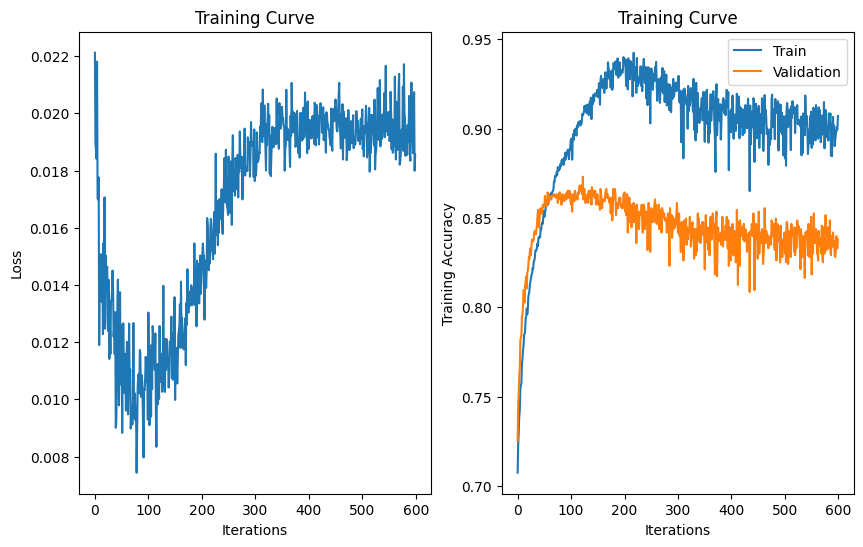

Final Training Accuracy: 0.906982421875
Final Validation Accuracy: 0.837890625


In [17]:
train(model, mnist_train, mnist_val,num_epochs=600)

In [18]:
print(list(model.parameters()))

[Parameter containing:
tensor([[ 1.4314e-05, -2.2745e-04, -1.2161e-03,  ..., -1.2940e-03,
         -2.2093e-03,  8.0859e-05],
        [-1.6196e-05, -1.0413e-05,  2.6160e-05,  ..., -8.9849e-04,
          1.6342e-03, -6.8083e-05],
        [ 1.8064e-05,  3.7748e-05,  2.5784e-07,  ..., -4.7359e-04,
          1.8001e-03, -5.3831e-05],
        ...,
        [ 3.4239e-05,  7.6247e-06, -9.8746e-05,  ...,  3.9647e-04,
         -2.7539e-04, -1.1054e-04],
        [-2.3534e-05, -2.4867e-05, -4.6524e-05,  ...,  5.5526e-04,
         -3.1419e-04, -1.6484e-05],
        [ 1.7256e-05,  1.7663e-05,  5.9415e-05,  ...,  1.8693e-03,
         -5.6444e-04, -5.4064e-05]], requires_grad=True), Parameter containing:
tensor([-8.6777e-06, -1.2319e-05, -3.9613e-06, -1.2619e-05,  8.3243e-06,
        -1.5021e-05, -1.3316e-05, -3.4050e-06, -4.4167e-06, -8.6036e-06,
         8.1479e-07, -2.0567e-06,  6.3255e-08, -7.0331e-06, -1.3792e-05,
        -6.0261e-06,  1.2794e-06, -1.3002e-05,  6.6040e-06, -5.1657e-06,
        -9

# Saving and loading the model

In [19]:
#Save the model into your working directory
#Download it to your machine. (Or you can save it to Drive)
torch.save(model.state_dict(), 'FashionMnist_checkpoint.pth')

In [22]:
a = torch.load('FashionMnist_checkpoint.pth')

/var/folders/15/8lcxwsvj7ql4y4cmdw2m1_y00000gn/T/ipykernel_19053/3955175377.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = torch.load('FashionMnist_checkpoint.pth')

In [23]:
a

OrderedDict([('1.weight',
              tensor([[ 1.4314e-05, -2.2745e-04, -1.2161e-03,  ..., -1.2940e-03,
                       -2.2093e-03,  8.0859e-05],
                      [-1.6196e-05, -1.0413e-05,  2.6160e-05,  ..., -8.9849e-04,
                        1.6342e-03, -6.8083e-05],
                      [ 1.8064e-05,  3.7748e-05,  2.5784e-07,  ..., -4.7359e-04,
                        1.8001e-03, -5.3831e-05],
                      ...,
                      [ 3.4239e-05,  7.6247e-06, -9.8746e-05,  ...,  3.9647e-04,
                       -2.7539e-04, -1.1054e-04],
                      [-2.3534e-05, -2.4867e-05, -4.6524e-05,  ...,  5.5526e-04,
                       -3.1419e-04, -1.6484e-05],
                      [ 1.7256e-05,  1.7663e-05,  5.9415e-05,  ...,  1.8693e-03,
                       -5.6444e-04, -5.4064e-05]])),
             ('1.bias',
              tensor([-8.6777e-06, -1.2319e-05, -3.9613e-06, -1.2619e-05,  8.3243e-06,
                      -1.5021e-05, -1.3316e-05,

In [24]:
#Reloading the saved model
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28*28, num_L1_out),
                      nn.BatchNorm1d(num_L1_out),
                      nn.ReLU(),
                      # Add a dropout layer after the first fully connected layer
                      nn.Dropout(dropout),
                      nn.Linear(num_L1_out,num_L2_out),
                      nn.BatchNorm1d(num_L2_out),
                      nn.ReLU(),
                      # Add a dropout layer after the 2nd fully connected layer
                      nn.Dropout(dropout),
                      nn.Linear(num_L2_out,num_output)) #This should be the model you trained.

model.load_state_dict(torch.load('FashionMnist_checkpoint.pth'))
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=180, bias=True)
  (2): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=180, out_features=180, bias=True)
  (6): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=180, out_features=10, bias=True)
)


/var/folders/15/8lcxwsvj7ql4y4cmdw2m1_y00000gn/T/ipykernel_19053/2610293914.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FashionMni

In [25]:
#You would not do this, but as we have a small NN we can print out
#the params.

# Option 1: If you want params + labels (weight or bias)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

1.weight tensor([[ 1.4314e-05, -2.2745e-04, -1.2161e-03,  ..., -1.2940e-03,
         -2.2093e-03,  8.0859e-05],
        [-1.6196e-05, -1.0413e-05,  2.6160e-05,  ..., -8.9849e-04,
          1.6342e-03, -6.8083e-05],
        [ 1.8064e-05,  3.7748e-05,  2.5784e-07,  ..., -4.7359e-04,
          1.8001e-03, -5.3831e-05],
        ...,
        [ 3.4239e-05,  7.6247e-06, -9.8746e-05,  ...,  3.9647e-04,
         -2.7539e-04, -1.1054e-04],
        [-2.3534e-05, -2.4867e-05, -4.6524e-05,  ...,  5.5526e-04,
         -3.1419e-04, -1.6484e-05],
        [ 1.7256e-05,  1.7663e-05,  5.9415e-05,  ...,  1.8693e-03,
         -5.6444e-04, -5.4064e-05]])
1.bias tensor([-8.6777e-06, -1.2319e-05, -3.9613e-06, -1.2619e-05,  8.3243e-06,
        -1.5021e-05, -1.3316e-05, -3.4050e-06, -4.4167e-06, -8.6036e-06,
         8.1479e-07, -2.0567e-06,  6.3255e-08, -7.0331e-06, -1.3792e-05,
        -6.0261e-06,  1.2794e-06, -1.3002e-05,  6.6040e-06, -5.1657e-06,
        -9.8207e-07,  1.1286e-05, -3.1157e-06, -2.2864e-06, 

In [26]:
# Option 2: just params
print(list(model.parameters()))

[Parameter containing:
tensor([[ 1.4314e-05, -2.2745e-04, -1.2161e-03,  ..., -1.2940e-03,
         -2.2093e-03,  8.0859e-05],
        [-1.6196e-05, -1.0413e-05,  2.6160e-05,  ..., -8.9849e-04,
          1.6342e-03, -6.8083e-05],
        [ 1.8064e-05,  3.7748e-05,  2.5784e-07,  ..., -4.7359e-04,
          1.8001e-03, -5.3831e-05],
        ...,
        [ 3.4239e-05,  7.6247e-06, -9.8746e-05,  ...,  3.9647e-04,
         -2.7539e-04, -1.1054e-04],
        [-2.3534e-05, -2.4867e-05, -4.6524e-05,  ...,  5.5526e-04,
         -3.1419e-04, -1.6484e-05],
        [ 1.7256e-05,  1.7663e-05,  5.9415e-05,  ...,  1.8693e-03,
         -5.6444e-04, -5.4064e-05]], requires_grad=True), Parameter containing:
tensor([-8.6777e-06, -1.2319e-05, -3.9613e-06, -1.2619e-05,  8.3243e-06,
        -1.5021e-05, -1.3316e-05, -3.4050e-06, -4.4167e-06, -8.6036e-06,
         8.1479e-07, -2.0567e-06,  6.3255e-08, -7.0331e-06, -1.3792e-05,
        -6.0261e-06,  1.2794e-06, -1.3002e-05,  6.6040e-06, -5.1657e-06,
        -9

## Going further

At this point, we can begin tuning hyperparameters, and tweak the architecture of our network to improve our validation accuracy. We can also check for any underfitting or overfitting. We will see how to do this in the next few lectures and classes.